In [110]:
!conda install seaborn

'conda' is not recognized as an internal or external command,
operable program or batch file.


In [109]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly 

ImportError: No module named 'seaborn'

In [2]:
#Instruct Jupyter to show plots
%matplotlib inline

## Read in the data
Read in the CSV saved in the last step and convert the data types. 

In [3]:
#Load the saved csv file
df = pd.read_csv('GageData.csv')

In [4]:
#Confirm it looks good
df.head()

,agency_cd,site_no,datetime,discharge,Confidence
0,USGS,2089000,1930-10-01,210.0,A
1,USGS,2089000,1930-10-02,188.0,A
2,USGS,2089000,1930-10-03,200.0,A
3,USGS,2089000,1930-10-04,200.0,A
4,USGS,2089000,1930-10-05,200.0,A


In [5]:
#Show the data types of each column
df.dtypes

agency_cd      object
site_no         int64
datetime       object
discharge     float64
Confidence     object
dtype: object

In [6]:
#Convert datetime to an actual datetime object
df['datetime'] = pd.to_datetime(df['datetime'],format=('%Y-%m-%d'))
df.dtypes

agency_cd             object
site_no                int64
datetime      datetime64[ns]
discharge            float64
Confidence            object
dtype: object

In [44]:
#Setting the date time as the index allows time slicing
df.index = df.datetime

## Create a scatterplot of daily discharge data
https://chrisalbon.com/python/data_visualization/matplotlib_scatterplot_from_pandas/
http://earthpy.org/pandas-basics.html

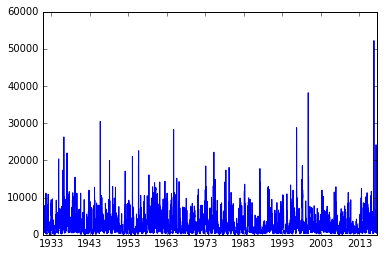

In [108]:
#Pandas can create line plots with a specified X and Y column
plt.plot(df['datetime'], df['discharge']);

In [ ]:
#Create a figure canvas
fig1 = plt.figure()
#

In [59]:
#We can slice specific times
dfPre = df['1950-01-01':'1979-12-31']
dfPost = df['1984-01-01':'2017-12-31']

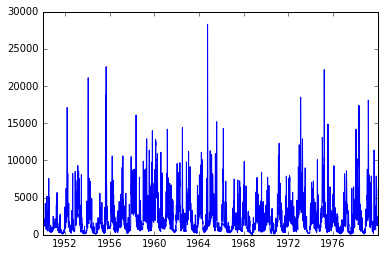

In [60]:
#And plot them too
plt.plot(dfPre['datetime'],dfPre['discharge']);

### Creating derived columns

In [8]:
#Convert from cfs to mps (1 CFS = 0.028316847 MPS)
df['mps'] = df['discharge'] * 0.028316847

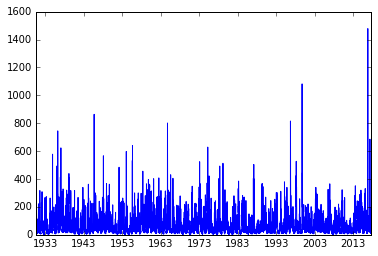

In [10]:
#Replot
plt.plot(df['datetime'],df['mps']);

In [ ]:
#Convert from csf to mgd (1 CFS = 0.53817 MGD)

In [ ]:
#Replot

### Summarize and Plot Streamflow data

##### Count of records by Confidence code

In [37]:
byConf = df[['datetime','Confidence']].groupby(['Confidence']).count()
byConf

,datetime
Confidence,
A,31371
A:e,41
P,336
P:e,2


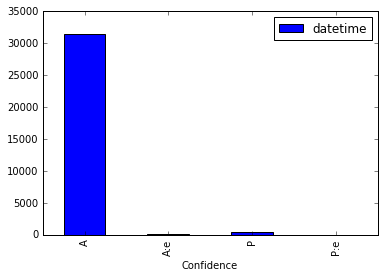

In [40]:
#https://pandas.pydata.org/pandas-docs/stable/visualization.html
byConf.plot(kind='bar');

##### Summarizing data with `Describe`

In [80]:
df['discharge'].describe(percentiles=[0.1,0.25,0.75,0.9])

count    31750.000000
mean      2456.054110
std       2812.195361
min         78.000000
10%        385.000000
25%        662.000000
50%       1380.000000
75%       3190.000000
90%       6180.000000
max      52200.000000
Name: discharge, dtype: float64

In [82]:
#Describe records before 1980 and after 1984 (using index slicing)
sumPre = df['discharge'][:"1980-01-01"].describe(percentiles=[0.1,0.25,0.75,0.9])
sumPost = df['discharge']["1984-01-01":].describe(percentiles=[0.1,0.25,0.75,0.9])

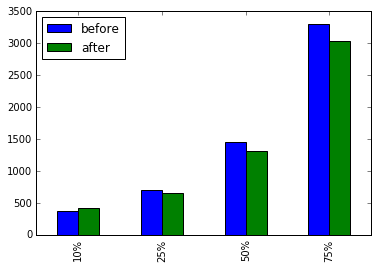

In [101]:
#Combine the pre and post summaries
dfSummary = pd.concat([sumPre,sumPost],axis=1)
dfSummary.columns = ("before","after")
dfSummary[4:-2].plot(kind='bar');

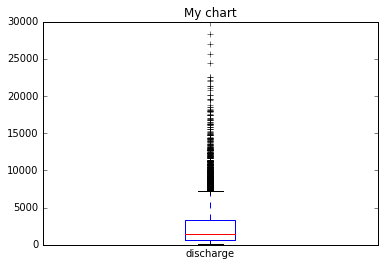

In [105]:
#Box plots
dfPre['discharge'].plot(
    kind='box',
    title='My chart'
);

In [ ]:
fig = plt.figure()
ax = 
plt.plot(dfPre)